In [1]:
from ast import literal_eval
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from rdkit.Chem import Descriptors, MolFromSmiles
from rdkit.Chem import QED
import matplotlib.pyplot as plt
import seaborn as sns
from pyvenn import venn

from utils import draw_venn

# Load dataset

In [2]:
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

In [3]:
final_df = pd.read_csv(f"{DATA_DIR}/processed/combined_bioassay_data.tsv", sep="\t")
final_df.head(2)

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast,chemical_class,compound_superclass,compound_pathway,gram-positive_label,gram-negative_label,fungi_label,acid-fast_label,best_class
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_34,5.0,5.0,NaN,6.0,"['Amino cyclitols', 'Aminoglycosides']","['Aminosugars and aminoglycosides', 'Polyols']",['Carbohydrates'],inactive,inactive,NaN,active,acid-fast
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_34,NaN,NaN,6.0,NaN,['Chalcones'],['Flavonoids'],['Shikimates and Phenylpropanoids'],NaN,NaN,active,NaN,fungi


# Chemphys properties

In [4]:
cmp_df = final_df[
    [
        "compound_smiles",
        "best_class",
        "gram-positive_label",
        "gram-negative_label",
        "fungi_label",
        "acid-fast_label",
    ]
].copy()
cmp_df = cmp_df.drop_duplicates()

cmp_df.head(2)

,compound_smiles,best_class,gram-positive_label,gram-negative_label,fungi_label,acid-fast_label
0,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,acid-fast,inactive,inactive,NaN,active
1,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,fungi,NaN,NaN,active,NaN


In [5]:
data = []
for smile in tqdm(cmp_df["compound_smiles"].values):
    mol = MolFromSmiles(smile)

    p = QED.properties(mol)
    alerts = [i for i in p][-1]

    data.append(
        {
            "compound_smiles": smile,
            "mol_wt": Descriptors.MolWt(mol),
            "tpsa": Descriptors.TPSA(mol),
            "fraction_sp3": Descriptors.FractionCSP3(mol),
            "n_hba": Descriptors.NumHAcceptors(mol),
            "n_hbd": Descriptors.NumHDonors(mol),
            "logp": Descriptors.MolLogP(mol),
            "alerts": alerts,
        }
    )

tmp_df = pd.DataFrame(data)

100%|██████████| 74202/74202 [01:54<00:00, 649.76it/s]


In [6]:
cmp_df = pd.merge(cmp_df, tmp_df, on="compound_smiles")

In [7]:
def check_ro5_violation(molecular_weight, n_hba, n_hbd, logp):
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return ro5_fulfilled

In [8]:
cmp_df["ro5_violation"] = cmp_df.apply(
    lambda x: check_ro5_violation(x["mol_wt"], x["n_hba"], x["n_hbd"], x["logp"]),
    axis=1,
)

In [9]:
k = cmp_df["ro5_violation"].value_counts().reset_index()
k.rename(columns={"index": "Ro5 Violation", "ro5_violation": "Count"}, inplace=True)
k["Normalized"] = k["Count"] / k["Count"].sum() * 100
k

,Ro5 Violation,Count,Normalized
0,True,55814,75.218997
1,False,18388,24.781003


In [10]:
t = []
for class_name in cmp_df["best_class"].unique():
    tmp = cmp_df[cmp_df["best_class"] == class_name]
    tmp = tmp.drop_duplicates(subset="compound_smiles")
    alert_counter = list(tmp["alerts"].value_counts().to_dict().values())
    no_alerts = alert_counter[0]
    combined_alerts = sum(alert_counter[1:])

    t.append(
        {
            "class": class_name,
            "n": len(tmp),
            "ro5_violation": tmp["ro5_violation"].value_counts().to_dict()[True],
            "structural_alerts": len(alert_counter),
            "no_alerts": f"{no_alerts} ({no_alerts / sum(alert_counter) * 100:.2f})",
            "alerts": f"{combined_alerts} ({combined_alerts / sum(alert_counter) * 100:.2f})",
        }
    )

pd.DataFrame(t)

,class,n,ro5_violation,structural_alerts,no_alerts,alerts
0,acid-fast,7306,6022,7,2393 (32.75),4913 (67.25)
1,fungi,9539,7670,8,2994 (31.39),6545 (68.61)
2,gram-negative,11354,8872,12,3171 (27.93),8183 (72.07)
3,gram-positive,26435,17578,9,8136 (30.78),18299 (69.22)
4,inactive,19568,15672,8,5783 (29.55),13785 (70.45)


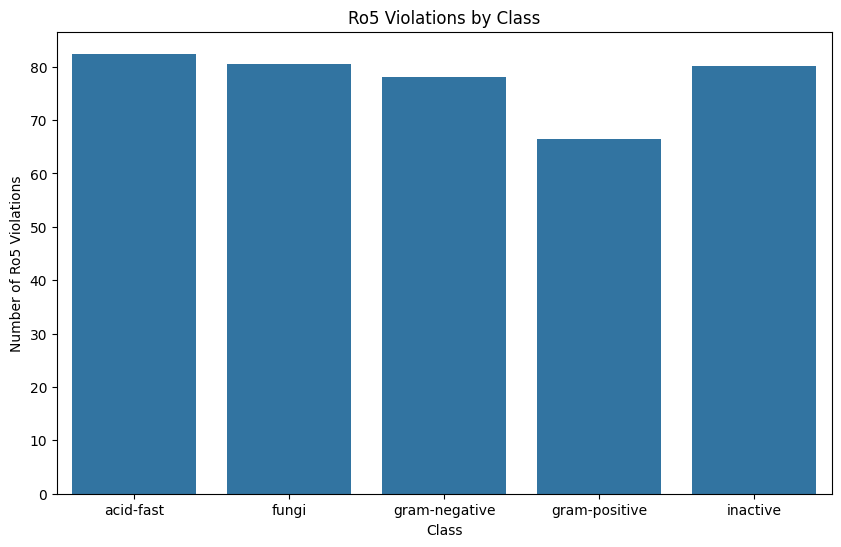

In [11]:
pp = pd.DataFrame(t)
pp["ro5_violation"] = pp["ro5_violation"] / pp["n"] * 100
plt.figure(figsize=(10, 6))
sns.barplot(x="class", y="ro5_violation", data=pp)
plt.ylabel("Number of Ro5 Violations")
plt.xlabel("Class")
plt.title("Ro5 Violations by Class")
plt.show()

In [12]:
t = []
for col in [
    "gram-positive_label",
    "gram-negative_label",
    "fungi_label",
    "acid-fast_label",
]:
    tmp = cmp_df[["compound_smiles", col, "alerts", "ro5_violation"]].dropna()
    tmp = tmp.drop_duplicates(subset="compound_smiles")
    for class_type in tmp[col].unique():
        tmp2 = tmp[tmp[col] == class_type]
        alert_counter = list(tmp2["alerts"].value_counts().to_dict().values())
        no_alerts = alert_counter[0]
        combined_alerts = sum(alert_counter[1:])

        t.append(
            {
                "class": col,
                "subclass": class_type,
                "n": len(tmp2),
                "ro5_violation": tmp2["ro5_violation"].value_counts().to_dict()[True],
                "structural_alerts": len(alert_counter),
                "no_alerts": f"{no_alerts} ({no_alerts / sum(alert_counter) * 100:.2f})",
                "alerts": f"{combined_alerts} ({combined_alerts / sum(alert_counter) * 100:.2f})",
            }
        )
pd.DataFrame(t)

,class,subclass,n,ro5_violation,structural_alerts,no_alerts,alerts
0,gram-positive_label,inactive,28568,21450,8,8149 (28.52),20419 (71.48)
1,gram-positive_label,active,17530,11511,9,5747 (32.78),11783 (67.22)
2,gram-negative_label,inactive,29415,22146,12,8257 (28.07),21158 (71.93)
3,gram-negative_label,active,11583,8651,9,3819 (32.97),7764 (67.03)
4,fungi_label,active,4282,3288,8,1293 (30.20),2989 (69.80)
5,fungi_label,inactive,13782,11492,8,4201 (30.48),9581 (69.52)
6,acid-fast_label,active,3958,3153,7,1217 (30.75),2741 (69.25)
7,acid-fast_label,inactive,7631,6491,8,2412 (31.61),5219 (68.39)


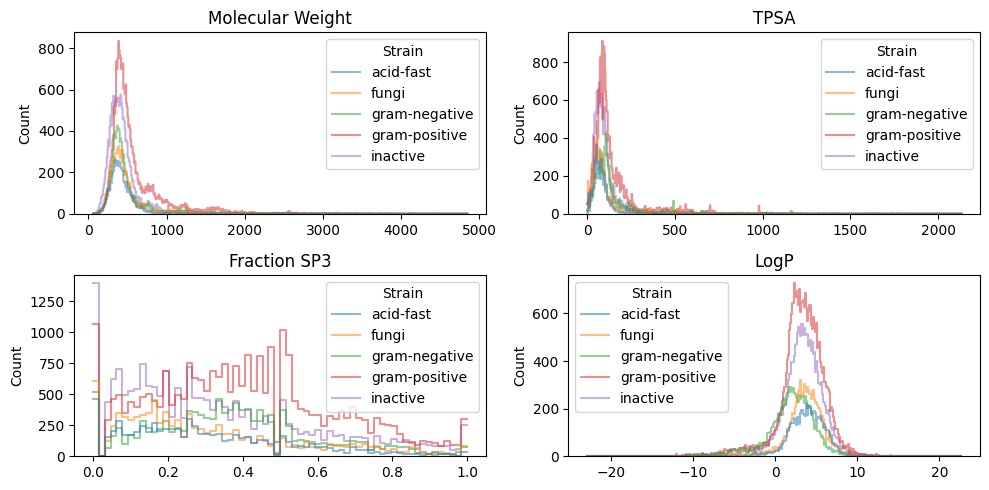

In [13]:
cmp_df.rename(columns={"best_class": "Strain"}, inplace=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5))

sns.histplot(
    data=cmp_df, x="mol_wt", hue="Strain", ax=ax1, alpha=0.5, element="step", fill=False
)
ax1.set_xlabel("")
ax1.set_title("Molecular Weight")

sns.histplot(
    data=cmp_df, x="tpsa", hue="Strain", ax=ax2, alpha=0.5, element="step", fill=False
)
ax2.set_xlabel("")
ax2.set_title("TPSA")

sns.histplot(
    data=cmp_df,
    x="fraction_sp3",
    hue="Strain",
    ax=ax3,
    alpha=0.5,
    element="step",
    fill=False,
)
ax3.set_xlabel("")
ax3.set_title("Fraction SP3")

sns.histplot(
    data=cmp_df, x="logp", hue="Strain", ax=ax4, alpha=0.5, element="step", fill=False
)
ax4.set_xlabel("")
ax4.set_title("LogP")

plt.tight_layout()
plt.show()

# Getting information on chemical classes

In [14]:
chem_class_dict = defaultdict(lambda: defaultdict(set))
chem_superclass_dict = defaultdict(lambda: defaultdict(set))
chem_pathway_dict = defaultdict(lambda: defaultdict(set))

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    (
        inchikey,
        smiles,
        source,
        gram_pos,
        gram_neg,
        fungi,
        acid_fast,
        class_info,
        superclass_info,
        pathway_info,
        gp_label,
        gn_label,
        fungi_label,
        af_label,
        best_class,
    ) = row

    if pd.isna(class_info):
        class_info = "[]"

    if pd.isna(superclass_info):
        superclass_info = "[]"

    if pd.isna(pathway_info):
        pathway_info = "[]"

    class_info = literal_eval(class_info)
    superclass_info = literal_eval(superclass_info)
    pathway_info = literal_eval(pathway_info)

    for c in class_info:
        chem_class_dict[best_class][c].add(inchikey)
        if not pd.isna(gp_label):
            chem_class_dict[f"gram-positive_{gp_label}"][c].add(inchikey)
        if not pd.isna(gn_label):
            chem_class_dict[f"gram-negative_{gn_label}"][c].add(inchikey)
        if not pd.isna(fungi_label):
            chem_class_dict[f"fungi_{fungi_label}"][c].add(inchikey)
        if not pd.isna(af_label):
            chem_class_dict[f"acid-fast_{af_label}"][c].add(inchikey)

    for c in superclass_info:
        chem_superclass_dict[best_class][c].add(inchikey)
        if not pd.isna(gp_label):
            chem_superclass_dict[f"gram-positive_{gp_label}"][c].add(inchikey)
        if not pd.isna(gn_label):
            chem_superclass_dict[f"gram-negative_{gn_label}"][c].add(inchikey)
        if not pd.isna(fungi_label):
            chem_superclass_dict[f"fungi_{fungi_label}"][c].add(inchikey)
        if not pd.isna(af_label):
            chem_superclass_dict[f"acid-fast_{af_label}"][c].add(inchikey)

    for c in pathway_info:
        chem_pathway_dict[best_class][c].add(inchikey)
        if not pd.isna(gp_label):
            chem_pathway_dict[f"gram-positive_{gp_label}"][c].add(inchikey)
        if not pd.isna(gn_label):
            chem_pathway_dict[f"gram-negative_{gn_label}"][c].add(inchikey)
        if not pd.isna(fungi_label):
            chem_pathway_dict[f"fungi_{fungi_label}"][c].add(inchikey)
        if not pd.isna(af_label):
            chem_pathway_dict[f"acid-fast_{af_label}"][c].add(inchikey)

100%|██████████| 74202/74202 [00:01<00:00, 37536.93it/s]


# Generate clustermap

In [15]:
def get_cluster_map(data_dict, save_fig=False):
    t = []

    for class_name, class_dict in data_dict.items():
        k = defaultdict(int)
        for subclass, compounds in class_dict.items():
            k[subclass] = len(compounds)
        k["Strain"] = class_name.capitalize()
        t.append(k)

    class_df = pd.DataFrame(t).fillna(0)
    class_df.set_index("Strain", inplace=True)
    print(f"Shape of the dataframe: {class_df.shape}")

    # Normalize the data
    scaler = MinMaxScaler()
    for col in class_df.columns:
        class_df[col] = scaler.fit_transform(class_df[[col]])

    g = sns.clustermap(
        class_df,
        cmap="Reds",
        method="ward",
        figsize=(15, 10),
        standard_scale=1,
    )
    g.ax_heatmap.set_yticklabels(
        g.ax_heatmap.get_ymajorticklabels(), fontsize=12, va="center"
    )

    # plt.tight_layout()
    if save_fig:
        g.savefig(f"{FIGURE_DIR}/figure_4.png", dpi=400)

    plt.show()

Shape of the dataframe: (13, 411)


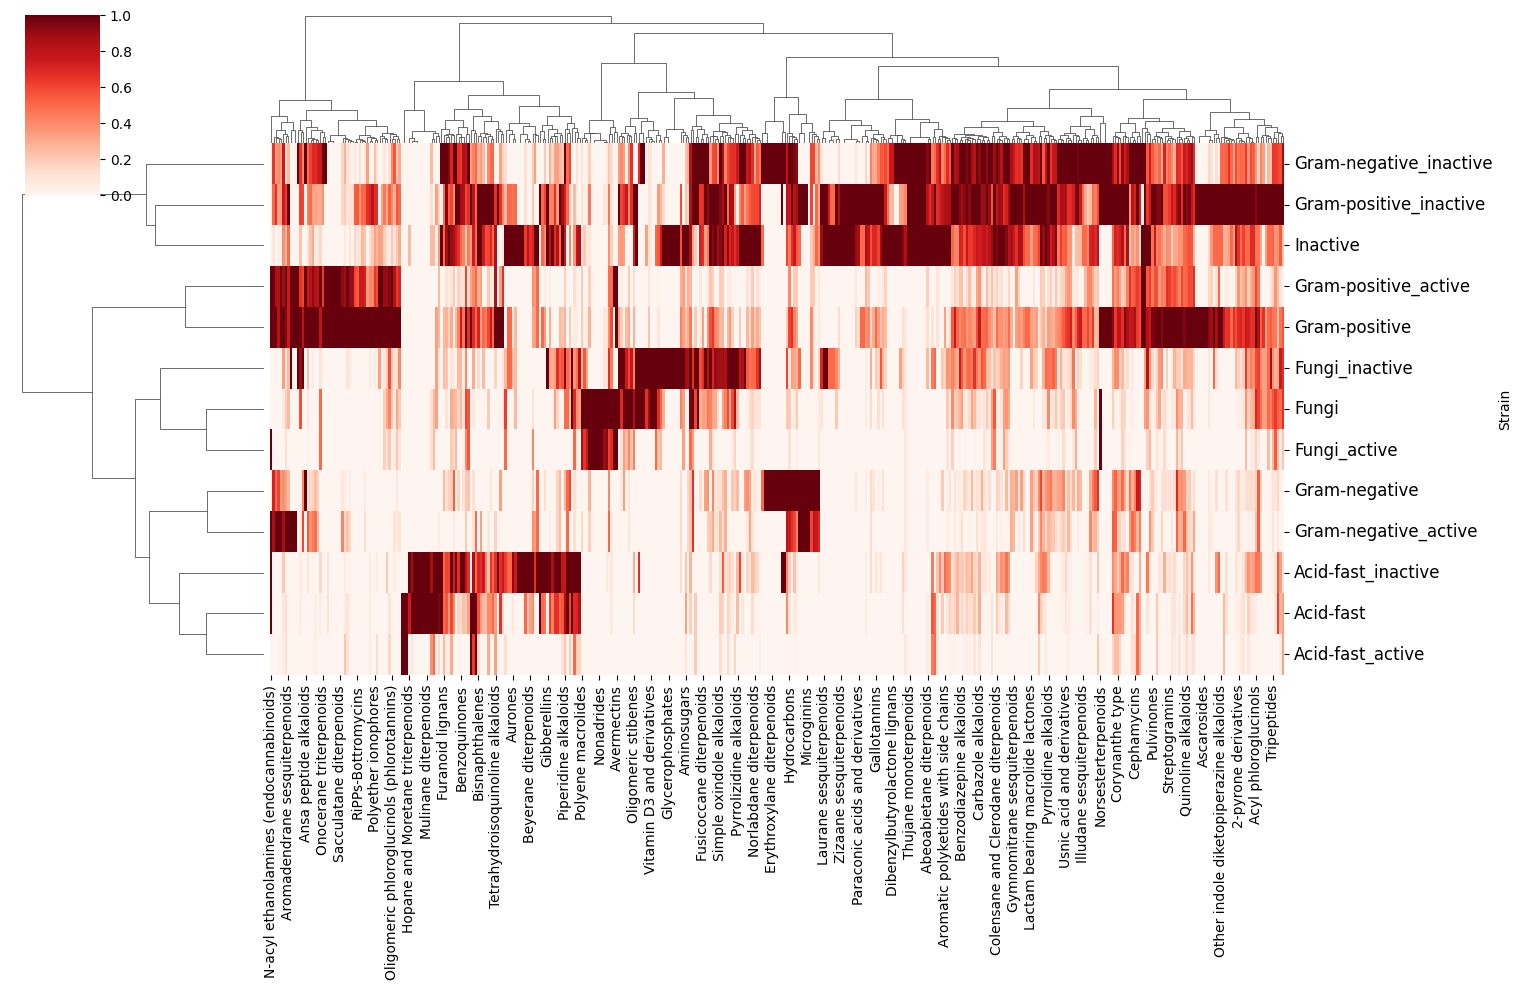

In [16]:
kk = get_cluster_map(chem_class_dict, save_fig=True)

Shape of the dataframe: (13, 67)


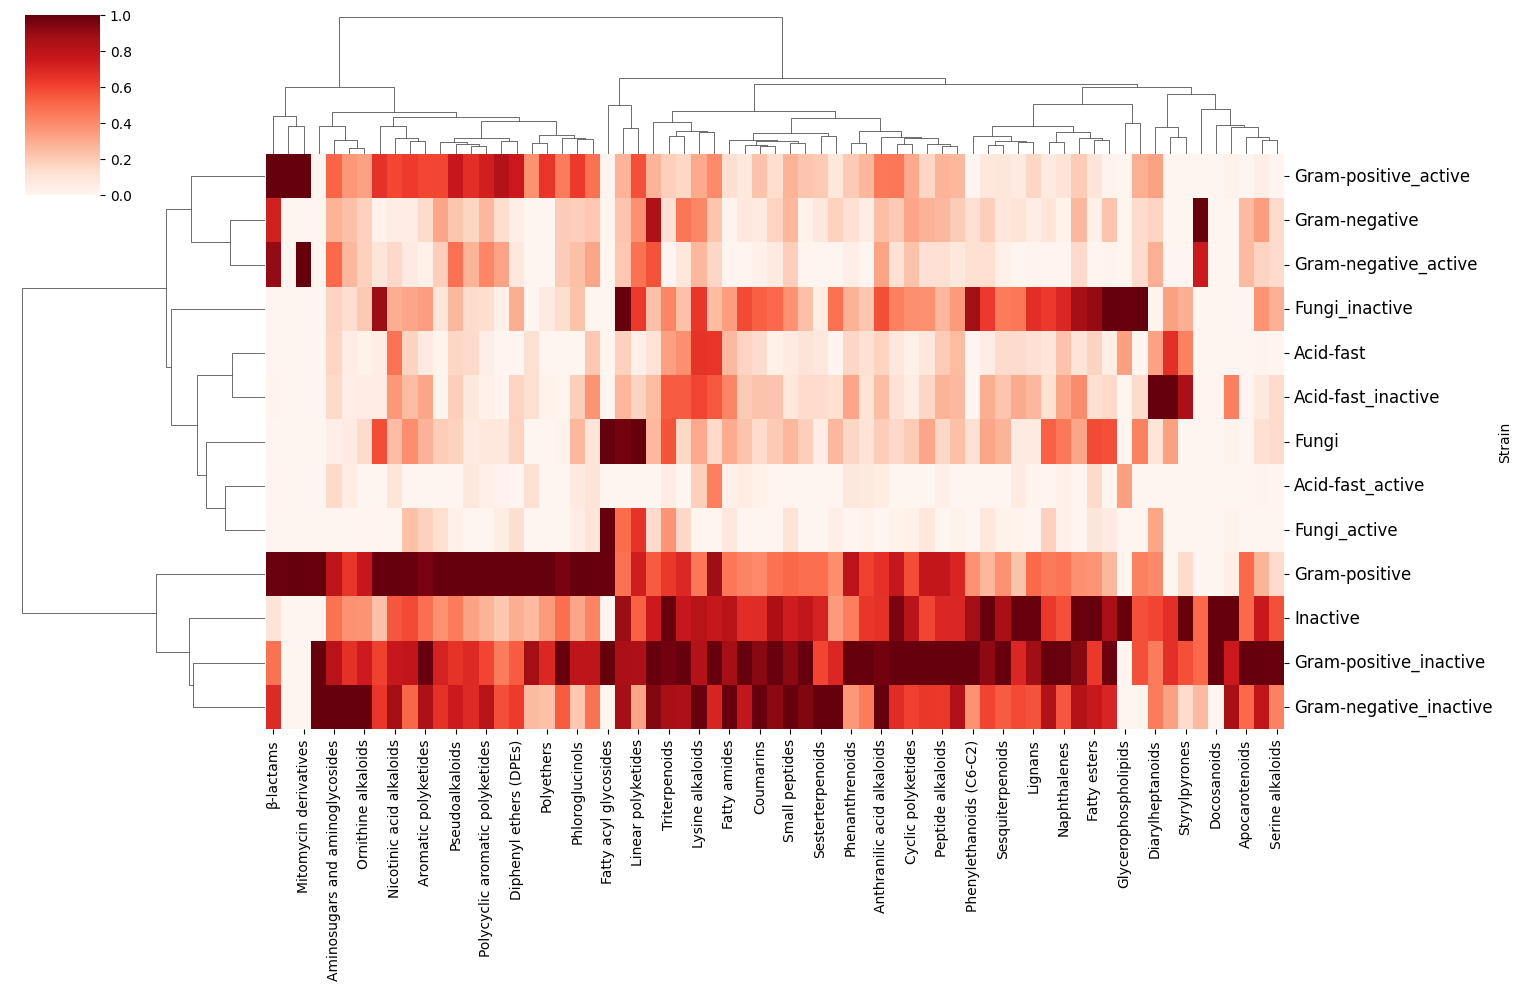

In [17]:
get_cluster_map(chem_superclass_dict)

Shape of the dataframe: (13, 7)


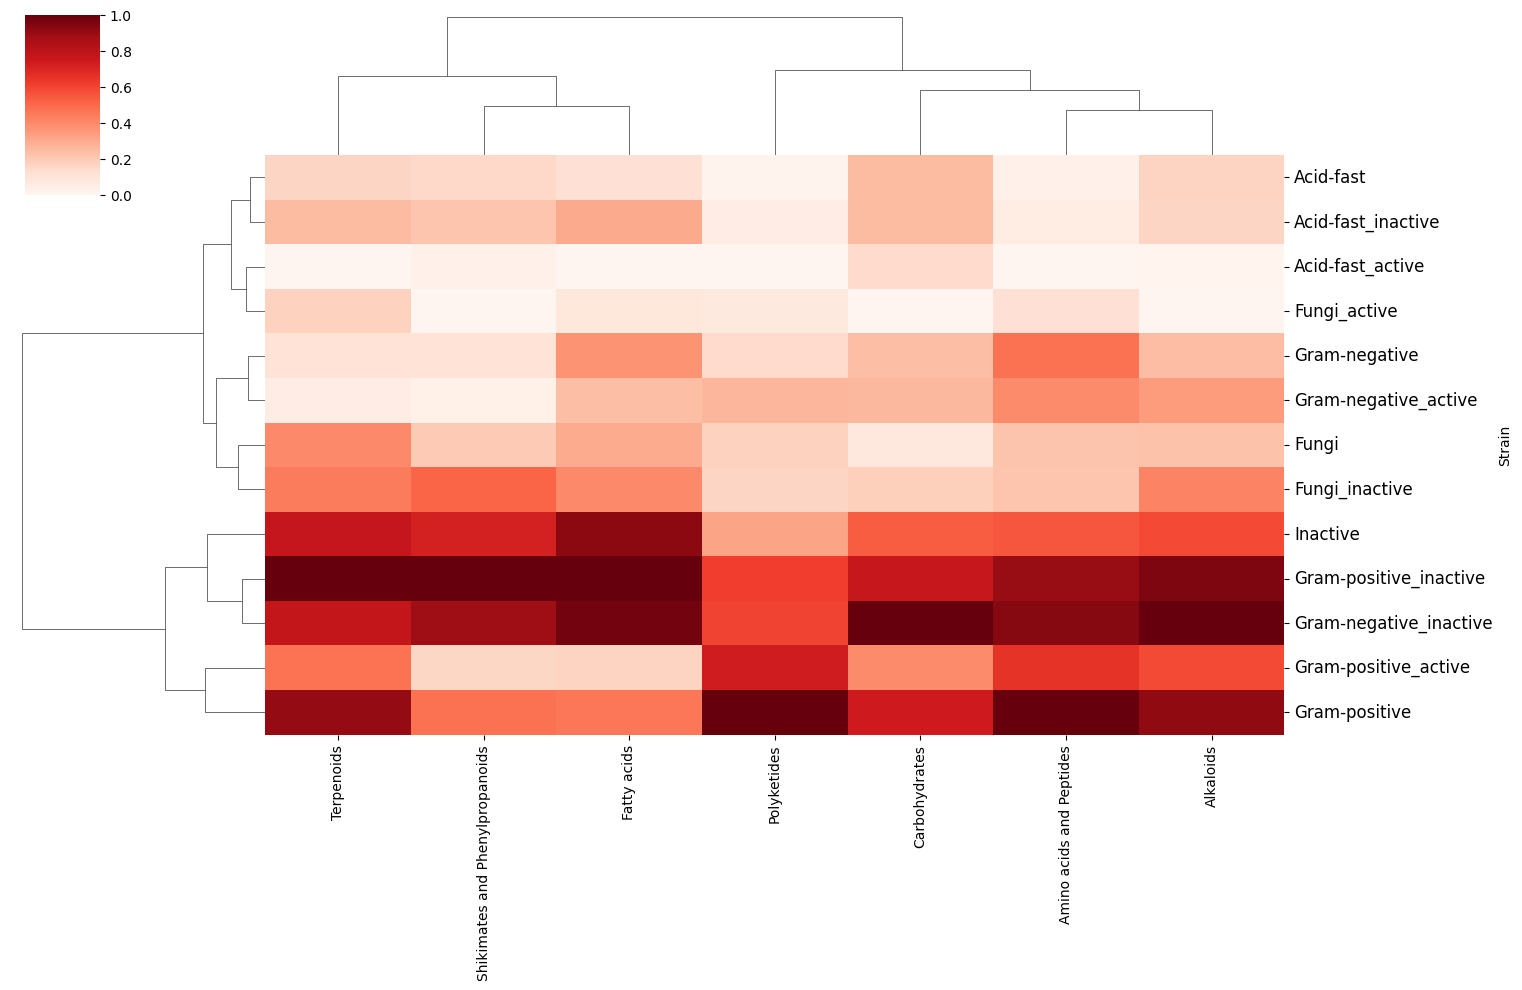

In [18]:
get_cluster_map(chem_pathway_dict)

# Deep dive into each category

In [19]:
def get_info_dict(data_dict):
    chem_class_counter_dict = {
        "gram-positive": {},
        "gram-negative": {},
        "fungi": {},
        "acid-fast": {},
        "inactive": {},
        "gram-positive_active": {},
        "gram-negative_active": {},
        "fungi_active": {},
        "acid-fast_active": {},
        "gram-positive_inactive": {},
        "gram-negative_inactive": {},
        "fungi_inactive": {},
        "acid-fast_inactive": {},
    }

    for k, v in data_dict.items():
        for kk, vv in v.items():
            chem_class_counter_dict[k][kk] = len(vv)

    gram_pos_classes = set(chem_class_counter_dict["gram-positive"].keys())
    gram_neg_classes = set(chem_class_counter_dict["gram-negative"].keys())
    fungi_classes = set(chem_class_counter_dict["fungi"].keys())
    acid_fast_classes = set(chem_class_counter_dict["acid-fast"].keys())
    inactive_classes = set(chem_class_counter_dict["inactive"].keys())

    labels = venn.get_labels(
        [
            gram_pos_classes,
            gram_neg_classes,
            fungi_classes,
            acid_fast_classes,
            inactive_classes,
        ]
    )
    fig, ax = venn.venn5(
        labels=labels,
        names=["Gram Positive", "Gram Negative", "Fungi", "Acid Fast", "Inactive"],
    )
    plt.show()
    return chem_class_counter_dict

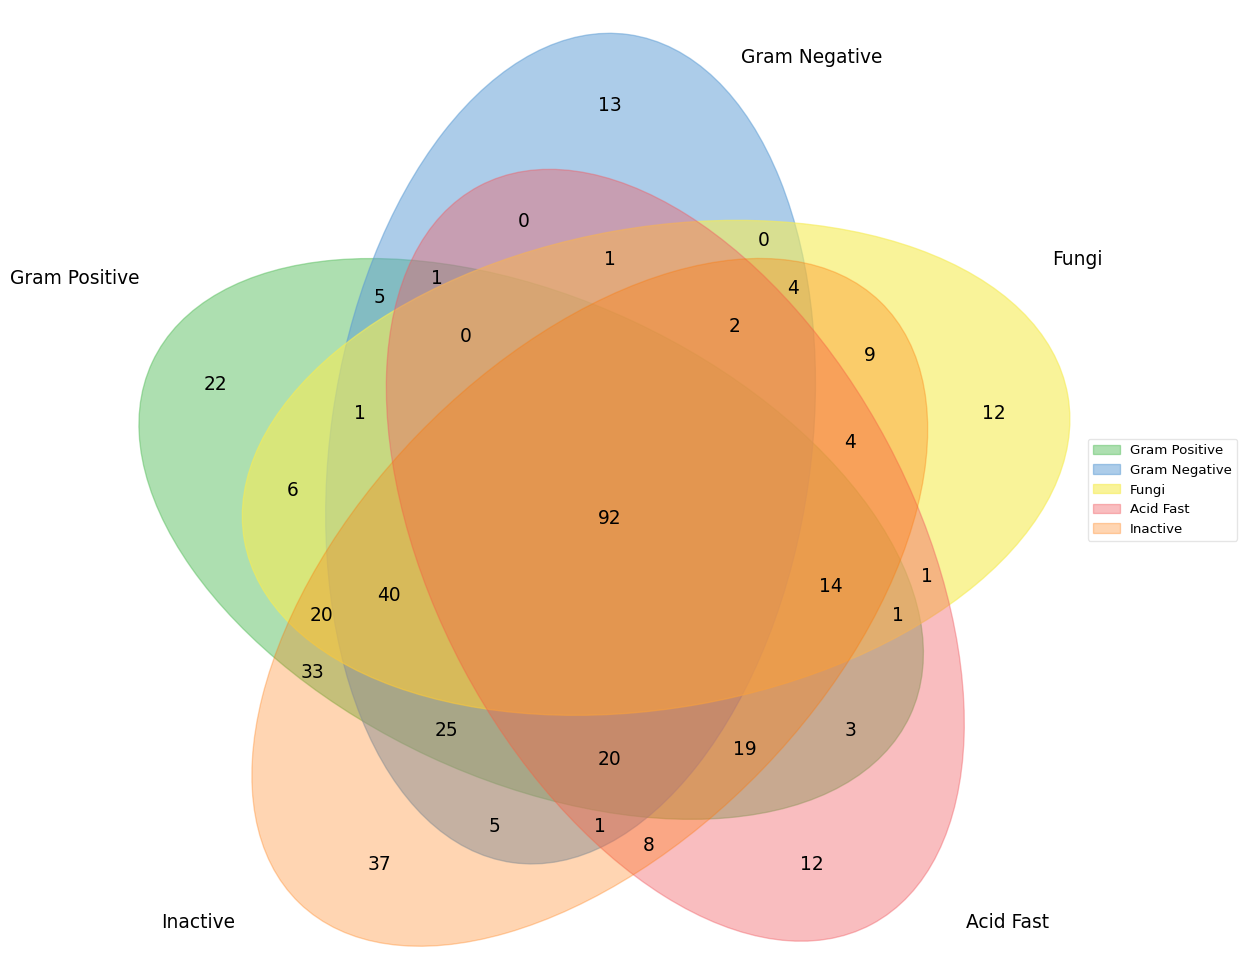

In [20]:
chem_class_counter_dict = get_info_dict(chem_class_dict)

In [21]:
gram_pos_classes = set(chem_class_counter_dict["gram-positive"].keys())
gram_neg_classes = set(chem_class_counter_dict["gram-negative"].keys())
fungi_classes = set(chem_class_counter_dict["fungi"].keys())
acid_fast_classes = set(chem_class_counter_dict["acid-fast"].keys())
inactive_classes = set(chem_class_counter_dict["inactive"].keys())

In [22]:
gram_pos_only = gram_pos_classes.difference(
    gram_neg_classes.union(fungi_classes)
    .union(acid_fast_classes)
    .union(inactive_classes)
)
gram_neg_only = gram_neg_classes.difference(
    gram_pos_classes.union(fungi_classes)
    .union(acid_fast_classes)
    .union(inactive_classes)
)
fungi_only = fungi_classes.difference(
    gram_neg_classes.union(gram_pos_classes)
    .union(acid_fast_classes)
    .union(inactive_classes)
)
acid_fast_only = acid_fast_classes.difference(
    gram_neg_classes.union(fungi_classes)
    .union(gram_pos_classes)
    .union(inactive_classes)
)
inactive_only = inactive_classes.difference(
    gram_neg_classes.union(fungi_classes)
    .union(gram_pos_classes)
    .union(acid_fast_classes)
)

In [23]:
len(gram_pos_only), len(gram_neg_only), len(fungi_only), len(acid_fast_only), len(
    inactive_only
)

(22, 13, 12, 12, 37)

In [24]:
def get_distiribution_plot(class_dict: dict, info_name: str):
    df_data = []

    for class_name in tqdm(class_dict):
        cmpd_couner = chem_class_counter_dict[info_name][class_name]
        df_data.append(
            {
                "class": class_name,
                "compound_count": cmpd_couner,
            }
        )

    df = pd.DataFrame(df_data)
    df.sort_values("compound_count", ascending=False, inplace=True)
    df["percentage"] = df["compound_count"] / df["compound_count"].sum() * 100
    df["percentage"] = df["percentage"].round(2)

    plt.figure(figsize=(12, 6))
    sns.barplot(x="class", y="percentage", data=df)
    plt.xticks(rotation=90)
    plt.show()

100%|██████████| 13/13 [00:00<00:00, 265980.25it/s]


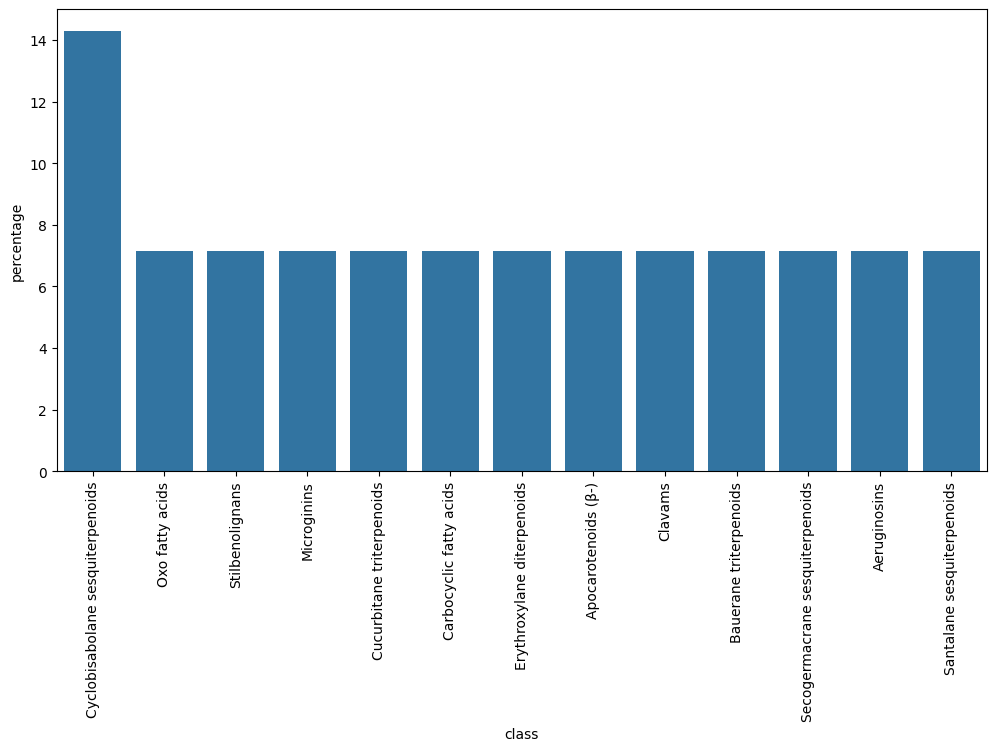

In [25]:
get_distiribution_plot(class_dict=gram_neg_only, info_name="gram-negative")

# Superclasses

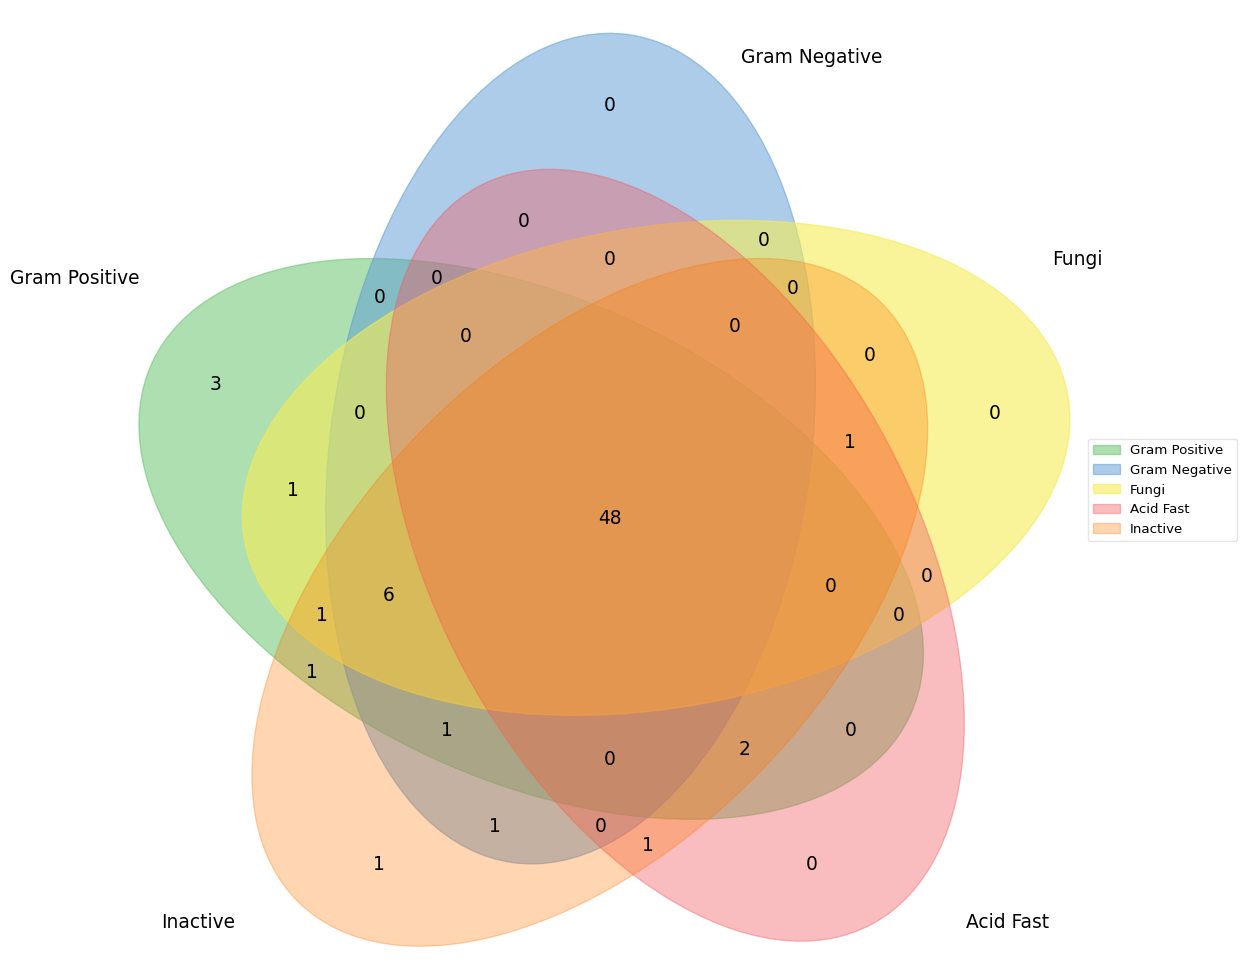

In [26]:
chem_superclass_counter_dict = get_info_dict(chem_superclass_dict)

# Pathways

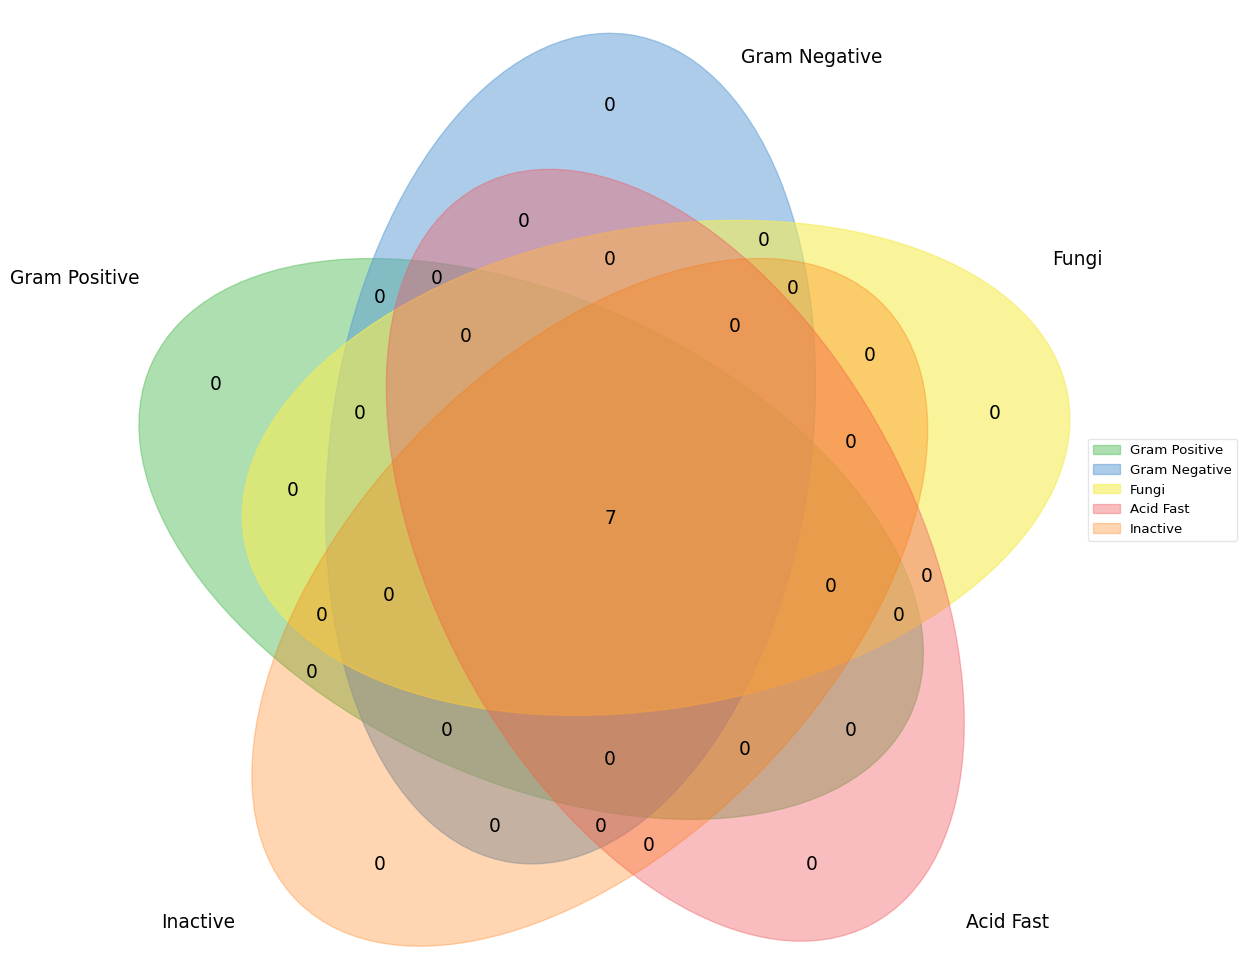

In [27]:
chem_pathway_counter_dict = get_info_dict(chem_pathway_dict)